## Topic: "Design and Compile (Perform) Transliteration, Topic Analysis and Sentiment/Emotions Associated  with the Presidential Address of India  till date."
## Title: Presidential Addresses at Parliament of India

## Dr S Radhakrishnan 1963-1967

## Install required libraries (uncomment and run if needed)
!pip install pandas numpy matplotlib seaborn nltk gensim scikit-learn pyLDAvis wordcloud pdfplumber spacy tqdm nrclex vaderSentiment indic-transliteration
!python -m spacy download en_core_web_sm

## 1. Importing Data and Corpus Creation

In [6]:
import os
from pathlib import Path
import pdfplumber
import pandas as pd

# automatically read all PDF files in the current folder
input_files = sorted(list(Path(r"/Users/himanj/Downloads/Presidential_Addresses_in_their_Tenures/Dr S Radhakrishnan 1963-1967").glob('*.pdf')))

if not input_files:
    print('No PDF files found in current folder. Place your PDFs here and re-run.')
records = []
for fp in input_files:
    text = ''
    with pdfplumber.open(fp) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + '\n'
    records.append({'filename': fp.name, 'text': text})

ta = pd.DataFrame(records)
print('Documents loaded:', len(ta))
ta.head()

Documents loaded: 5


filename  \
0  radhakrishnan_10_02_1964.pdf   
1  radhakrishnan_14_02_1966.pdf   
2  radhakrishnan_17_02_1965.pdf   
3  radhakrishnan_18_02_1963.pdf   
4  radhakrishnan_18_03_1967.pdf   

                                                text  
0  ADDRESS TO PARLIAMENT—10 FEBRUARY 1964*\nLok S...  
1  ADDRESS TO PARLIAMENT—14 FEBRUARY 1966\nLok Sa...  
2  ADDRESS TO PARLIAMENT—17 FEBRUARY 1965\nLok Sa...  
3  ADDRESS TO PARLIAMENT—18 FEBRUARY 1963\nLok Sa...  
4  ADDRESS TO PARLIAMENT—18 MARCH 1967\nLok Sabha...

In [7]:
import os
print(os.listdir("/Users/himanj/Downloads/Presidential_Addresses_in_their_Tenures/Dr S Radhakrishnan 1963-1967"))


['radhakrishnan_10_02_1964.pdf', 'radhakrishnan_14_02_1966.pdf', 'radhakrishnan_18_02_1963.pdf', 'radhakrishnan_18_03_1967.pdf', 'radhakrishnan_17_02_1965.pdf']


## 2. Data Preprocessing and Descriptive Analytics

In [4]:
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import spacy
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from collections import Counter

# NLTK downloads (if not done earlier)
nltk.download('punkt')
nltk.download('stopwords')

# Stopwords
stop_words = set(stopwords.words('english'))
custom_stops = {'honourable','members','government','president','india','shall','may','would'}
stop_words |= custom_stops

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])

# --- Step 1: Pre-tokenize texts ---
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep only letters/spaces
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if (t not in stop_words and len(t) > 2)]
    return tokens

ta['tokens_raw'] = ta['text'].apply(clean_and_tokenize)

# --- Step 2: Build bigram/trigram models ---
bigram = Phrases(ta['tokens_raw'], min_count=5, threshold=10)
trigram = Phrases(bigram[ta['tokens_raw']], threshold=10)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# --- Step 3: Lemmatization + apply bigrams/trigrams ---
def preprocess_text(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [t.lemma_ for t in doc if (t.lemma_ not in stop_words and len(t.lemma_) > 2)]
    lemmas = trigram_mod[bigram_mod[lemmas]]
    return lemmas

ta['tokens'] = ta['tokens_raw'].apply(preprocess_text)

# --- Extra Descriptive Stats ---
ta['char_count'] = ta['text'].str.len()
ta['word_count'] = ta['text'].apply(lambda t: len(word_tokenize(t)))
ta['sentence_count'] = ta['text'].apply(lambda t: len(sent_tokenize(t)))
ta['unique_tokens'] = ta['tokens'].apply(lambda x: len(set(x)))
ta['top_words'] = ta['tokens'].apply(lambda x: Counter(x).most_common(10))

# Display results
print(ta[['filename','word_count','unique_tokens','top_words']])


[nltk_data] Downloading package punkt to /Users/himanj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himanj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                       filename  word_count  unique_tokens  \
0  radhakrishnan_10_02_1964.pdf        3109            786   
1  radhakrishnan_14_02_1966.pdf        2801            686   
2  radhakrishnan_17_02_1965.pdf        3072            777   
3  radhakrishnan_18_02_1963.pdf        3194            764   
4  radhakrishnan_18_03_1967.pdf        2552            636   

                                           top_words  
0  [(pakistan, 18), (year, 15), (country, 15), (m...  
1  [(year, 17), (people, 15), (country, 14), (mak...  
2  [(year, 16), (country, 16), (also, 13), (incre...  
3  [(country, 16), (parliament, 15), (defence, 12...  
4  [(state, 15), (make, 12), (parliament, 9), (co...  


In [5]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter

# Downloads (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# --- Descriptive stats ---
ta['char_count'] = ta['text'].str.len()
ta['word_count'] = ta['text'].apply(lambda t: len(word_tokenize(t)))
ta['sentence_count'] = ta['text'].apply(lambda t: len(sent_tokenize(t)))
print(ta[['filename','word_count','sentence_count','char_count']])

# --- Stopwords ---
stop_words = set(stopwords.words('english'))
custom_stops = {'honourable','members','government','president','india','shall','may','would'}
stop_words |= custom_stops

# --- Preprocessing with Lemmatization + Bigram detection ---
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # lowercase + remove non-letters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)

    # tokenize
    toks = word_tokenize(text)

    # remove stopwords + short words
    toks = [t for t in toks if (t not in stop_words and len(t) > 2)]

    # lemmatization
    toks = [lemmatizer.lemmatize(t) for t in toks]

    # bigram detection (simple: join consecutive frequent words)
    bigrams = ['_'.join([toks[i], toks[i+1]]) for i in range(len(toks)-1)]
    toks = toks + bigrams

    return toks

ta['tokens'] = ta['text'].apply(preprocess_text)

# --- Extra stats ---
ta['unique_tokens'] = ta['tokens'].apply(lambda x: len(set(x)))
ta['top_words'] = ta['tokens'].apply(lambda x: Counter(x).most_common(10))

# Show results
print(ta[['filename','word_count','unique_tokens','top_words']])


[nltk_data] Downloading package punkt to /Users/himanj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himanj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/himanj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/himanj/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                       filename  word_count  sentence_count  char_count
0  radhakrishnan_10_02_1964.pdf        3109             116       17506
1  radhakrishnan_14_02_1966.pdf        2801             130       15405
2  radhakrishnan_17_02_1965.pdf        3072             151       17088
3  radhakrishnan_18_02_1963.pdf        3194             123       17550
4  radhakrishnan_18_03_1967.pdf        2552             109       14716
                       filename  word_count  unique_tokens  \
0  radhakrishnan_10_02_1964.pdf        3109           2158   
1  radhakrishnan_14_02_1966.pdf        2801           1934   
2  radhakrishnan_17_02_1965.pdf        3072           2131   
3  radhakrishnan_18_02_1963.pdf        3194           2157   
4  radhakrishnan_18_03_1967.pdf        2552           1744   

                                           top_words  
0  [(pakistan, 18), (year, 17), (country, 15), (m...  
1  [(year, 23), (people, 15), (country, 14), (pla...  
2  [(year, 19), (plan, 17), (c

In [6]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /Users/himanj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/himanj/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himanj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/himanj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/himanj/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 3a. Determine number of topics using Coherence Scores


=== Coherence Scores by Number of Topics ===



num_topics    u_mass       c_v      c_uci    c_npmi
0            2 -4.894159  0.518113 -15.121568 -0.525612
1            3 -0.675107  0.448131 -14.375978 -0.488893
2            4 -0.743191  0.472383 -14.671938 -0.505571
3            5 -0.902302  0.466582 -14.872450 -0.516327
4            6 -1.680107  0.472820 -14.835420 -0.515651
5            7 -2.470138  0.480767 -14.917787 -0.517864
6            8 -3.866573  0.505025 -14.982592 -0.518476
7            9 -2.773659  0.519677 -14.887192 -0.514746
8           10 -2.287516  0.494139 -14.802853 -0.510615
9           11 -1.586487  0.507462 -14.684610 -0.506680
10          12 -2.705147  0.498267 -14.760144 -0.510105


=== Best Number of Topics (per coherence measure) ===
u_mass: 3
c_v: 9
c_uci: 3
c_npmi: 3


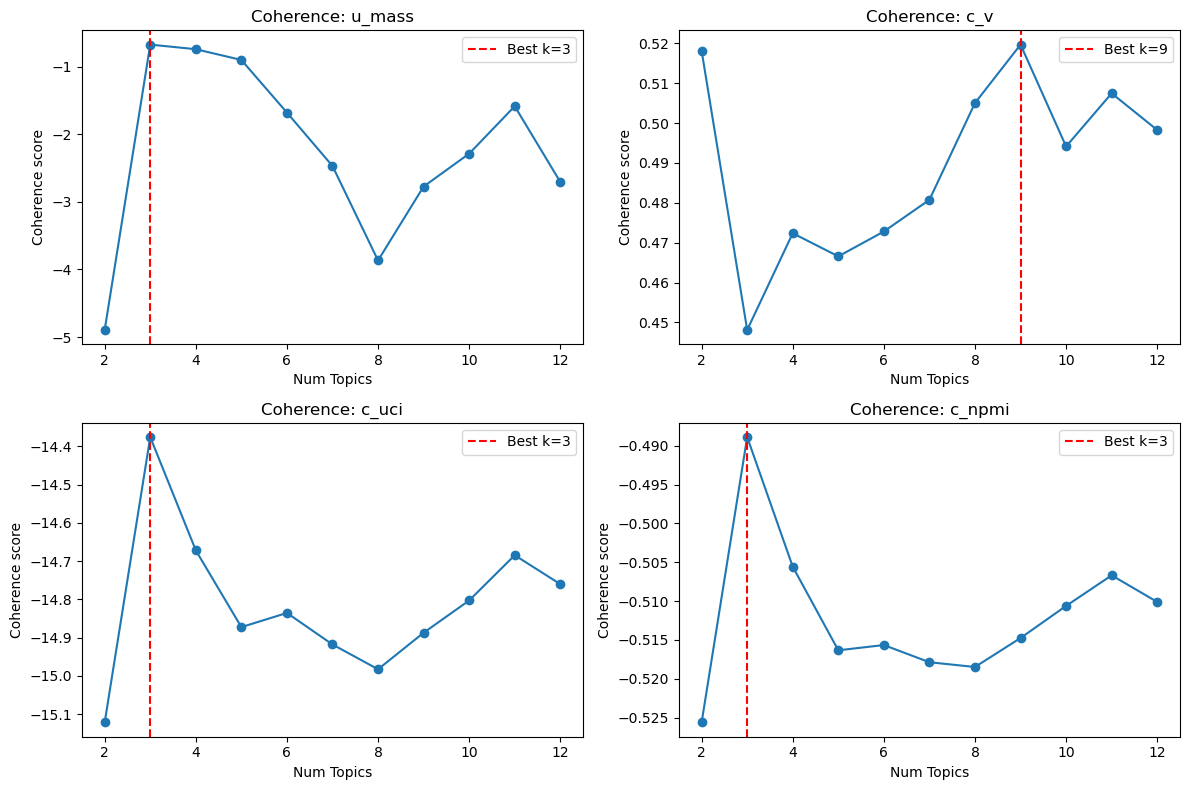

In [7]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd

if 'ta' in globals() and not ta.empty:
    dictionary = corpora.Dictionary(ta['tokens'])
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in ta['tokens']]

    def compute_coherence_values(dictionary, corpus, texts, start=2, limit=12, step=1):
        model_list = []
        coherence_values = {alg: [] for alg in ['u_mass','c_v','c_uci','c_npmi']}
        for num_topics in range(start, limit+1, step):
            model = models.LdaModel(
                corpus=corpus, id2word=dictionary, num_topics=num_topics,
                random_state=100, passes=10
            )
            model_list.append(model)
            for coh in coherence_values.keys():
                cm = CoherenceModel(
                    model=model, texts=texts, corpus=corpus,
                    dictionary=dictionary, coherence=coh
                )
                coherence_values[coh].append(cm.get_coherence())
        return model_list, coherence_values

    # --- Compute coherence values ---
    model_list, coherence_values = compute_coherence_values(
        dictionary, corpus, ta['tokens'], start=2, limit=12
    )

    # --- Convert results to DataFrame ---
    coherence_df = pd.DataFrame({'num_topics': range(2, 13)})
    for alg in coherence_values.keys():
        coherence_df[alg] = coherence_values[alg]

    # Display table
    print("\n=== Coherence Scores by Number of Topics ===\n")
    display(coherence_df)

    # --- Find best K per coherence type ---
    best_k = {}
    for alg in coherence_values.keys():
        scores = coherence_values[alg]
        k_values = list(range(2, 13))
        max_idx = scores.index(max(scores))
        best_k[alg] = k_values[max_idx]

    print("\n=== Best Number of Topics (per coherence measure) ===")
    for alg, k in best_k.items():
        print(f"{alg}: {k}")

    # --- Plot graphs with best K marked ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    algos = list(coherence_values.keys())
    for ax, alg in zip(axes.flatten(), algos):
        scores = coherence_values[alg]
        k_values = list(range(2, 13))
        ax.plot(k_values, scores, marker='o')
        ax.axvline(best_k[alg], color='r', linestyle='--', label=f'Best k={best_k[alg]}')
        ax.set_title(f'Coherence: {alg}')
        ax.set_xlabel('Num Topics')
        ax.set_ylabel('Coherence score')
        ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Run the preprocessing cell first to create tokens.')


## 3b. Train final LDA (choose best_k from coherence graphs)

In [8]:
from gensim import models

# Choose best_k based on coherence graphs. Change this value after inspecting graphs.
best_k = 6
if 'corpus' in globals() and 'dictionary' in globals():
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_k, random_state=100, passes=15)
    print('LDA trained with', best_k, 'topics')
else:
    print('Prepare corpus and dictionary first.')

LDA trained with 6 topics


In [9]:
from gensim.models import LdaMulticore, CoherenceModel

# --- Parameters ---
best_k = 6   # number of topics (change based on coherence analysis)
passes = 20
iterations = 400
chunksize = 200
random_state = 100

if 'corpus' in globals() and 'dictionary' in globals() and 'ta' in globals():
    # Train LDA model using multicore for faster performance
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=best_k,
        random_state=random_state,
        passes=passes,
        iterations=iterations,
        chunksize=chunksize,
        workers=4  # adjust to the number of CPU cores you have
    )
    print(f"LDA trained with {best_k} topics ✅")

    # --- Evaluate Coherence ---
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=ta['tokens'],   # tokenized texts from your DataFrame
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print("Coherence Score:", round(coherence_score, 4))

    # --- Display Topics ---
    print("\nTop words per topic:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}: {topic}")

    # --- Save the model for reuse ---
    lda_model.save("lda_model_textanalytics")
    print("\nModel saved as lda_model_textanalytics")
else:
    print("⚠️ Prepare corpus, dictionary, and tokenized texts (ta['tokens']) first.")


LDA trained with 6 topics ✅
Coherence Score: 0.4597

Top words per topic:
Topic 0: 0.001*"territory" + 0.001*"order" + 0.001*"november" + 0.001*"military" + 0.001*"union_territory" + 0.001*"though" + 0.001*"colombo" + 0.001*"africa" + 0.001*"scale" + 0.001*"citizen"
Topic 1: 0.009*"action" + 0.009*"minority" + 0.009*"africa" + 0.009*"territory" + 0.007*"property" + 0.007*"external_assistance" + 0.007*"talk" + 0.005*"significant" + 0.005*"steady" + 0.005*"west"
Topic 2: 0.011*"food" + 0.009*"recent" + 0.009*"machinery" + 0.007*"conference" + 0.007*"significant" + 0.007*"language" + 0.007*"affirmed" + 0.007*"threat" + 0.007*"shri" + 0.007*"income"
Topic 3: 0.011*"shastri" + 0.009*"bahadur_shastri" + 0.009*"irrigation_project" + 0.009*"man" + 0.009*"lal_bahadur" + 0.009*"conflict" + 0.009*"nearly" + 0.009*"bahadur" + 0.009*"lal" + 0.007*"death"
Topic 4: 0.013*"state_government" + 0.013*"food" + 0.011*"ordinance" + 0.011*"efficiency" + 0.011*"recommendation" + 0.008*"since" + 0.008*"leader

## 3c. Contribution of words in each topic (top 30 words)


Topic 0
territory       0.001492
order           0.001492
november        0.001491
military        0.001490
union_territory 0.001490
though          0.001490
colombo         0.001490
africa          0.001490
scale           0.001490
citizen         0.001489
north           0.001489
america         0.001489
also_given      0.001489
difference      0.001489
attack          0.001489
minority        0.001489
attained        0.001489
sikkim          0.001489
friendly_operative 0.001489
tarapore        0.001489
fifty           0.001489
resulted        0.001489
upward_trend    0.001489
committed       0.001489
talk            0.001489
democratic_socialist 0.001488
extent          0.001488
property        0.001488
nehru_speaker   0.001488
coal            0.001488


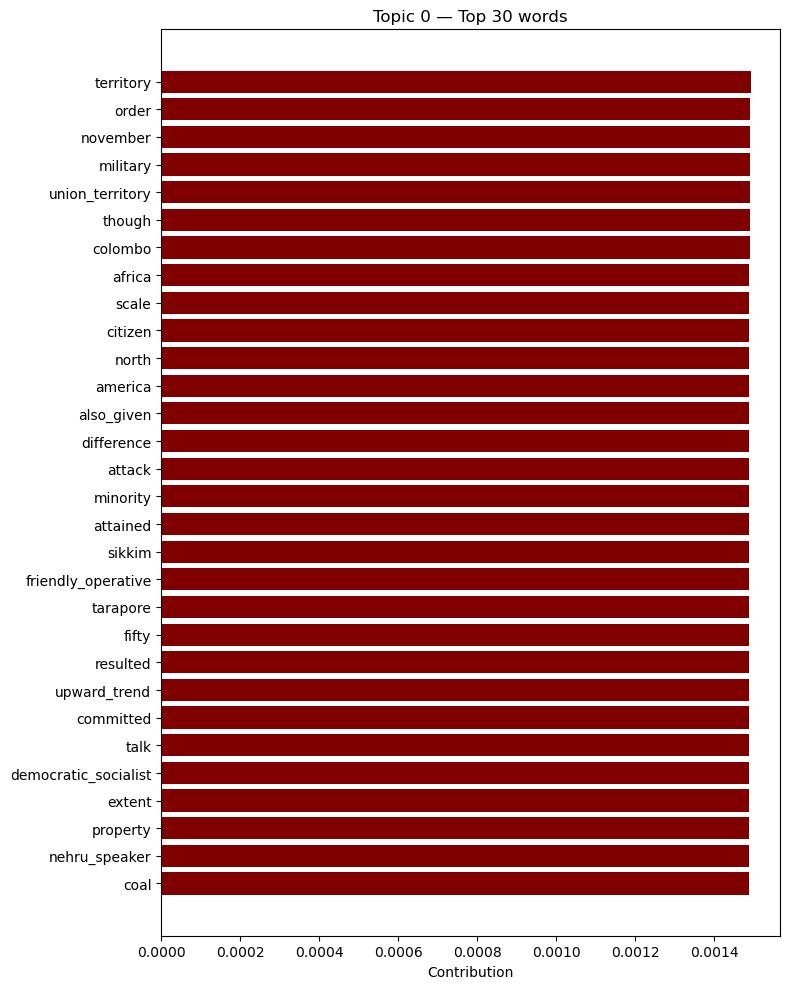


Topic 1
action          0.009095
minority        0.009094
africa          0.009094
territory       0.009093
property        0.006911
external_assistance 0.006911
talk            0.006911
significant     0.004729
steady          0.004729
west            0.004729
year_ended      0.004729
ended           0.004729
dedicated       0.004729
plan_target     0.004729
receiving       0.004729
premier         0.004729
anti            0.004729
confidence      0.004729
initiated       0.004729
continuing      0.004729
privilege       0.004729
life_property   0.004729
mutual          0.004729
genuine         0.004729
showed          0.004729
happy           0.004729
discussion      0.004729
peace_operation 0.004729
established     0.004729
death           0.004729


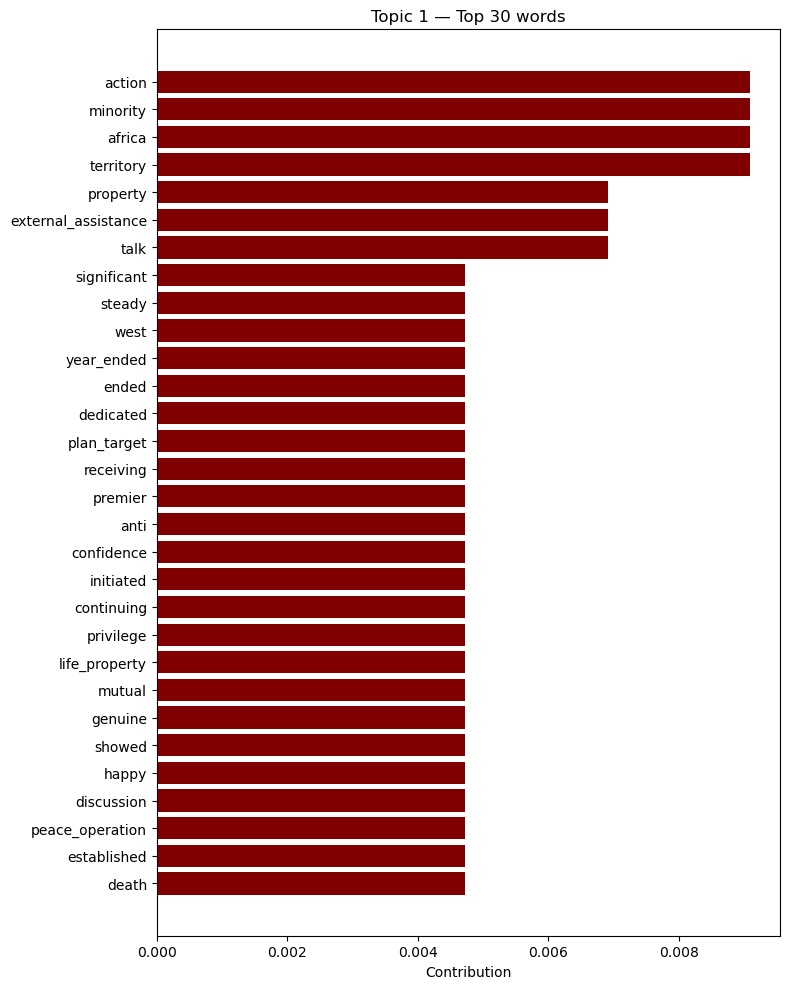


Topic 2
food            0.011155
recent          0.008996
machinery       0.008996
conference      0.006837
significant     0.006837
language        0.006837
affirmed        0.006837
threat          0.006837
shri            0.006837
income          0.006837
nearly          0.006837
rate_growth     0.006837
better          0.006837
importance      0.006837
event           0.006837
implementation  0.006837
steady          0.004678
stability_price 0.004678
fund            0.004678
speed           0.004678
action          0.004678
leader          0.004678
nation_world    0.004678
friend          0.004678
check           0.004678
earnings        0.004678
increase_per    0.004678
beginning       0.004678
minimum         0.004678
official_language 0.004678


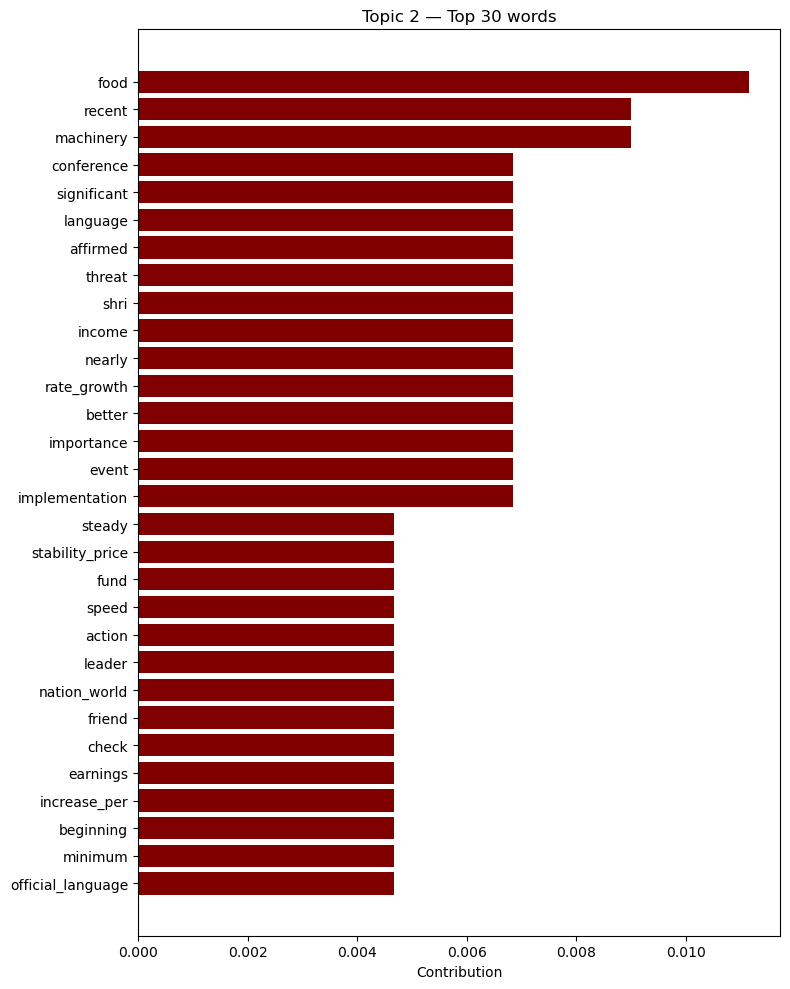


Topic 3
shastri         0.011253
bahadur_shastri 0.009075
irrigation_project 0.009075
man             0.009075
lal_bahadur     0.009075
conflict        0.009075
nearly          0.009075
bahadur         0.009075
lal             0.009075
death           0.006897
million_acre    0.006897
recent          0.006897
rise            0.006897
commissioned    0.004719
created         0.004719
government_people 0.004719
satisfaction    0.004719
context         0.004719
contribution    0.004719
relief          0.004719
affected        0.004719
quickly         0.004719
taken_ensure    0.004719
rate_growth     0.004719
within          0.004719
africa          0.004719
showed          0.004719
fourth_five     0.004719
reduced         0.004719
pradesh         0.004719


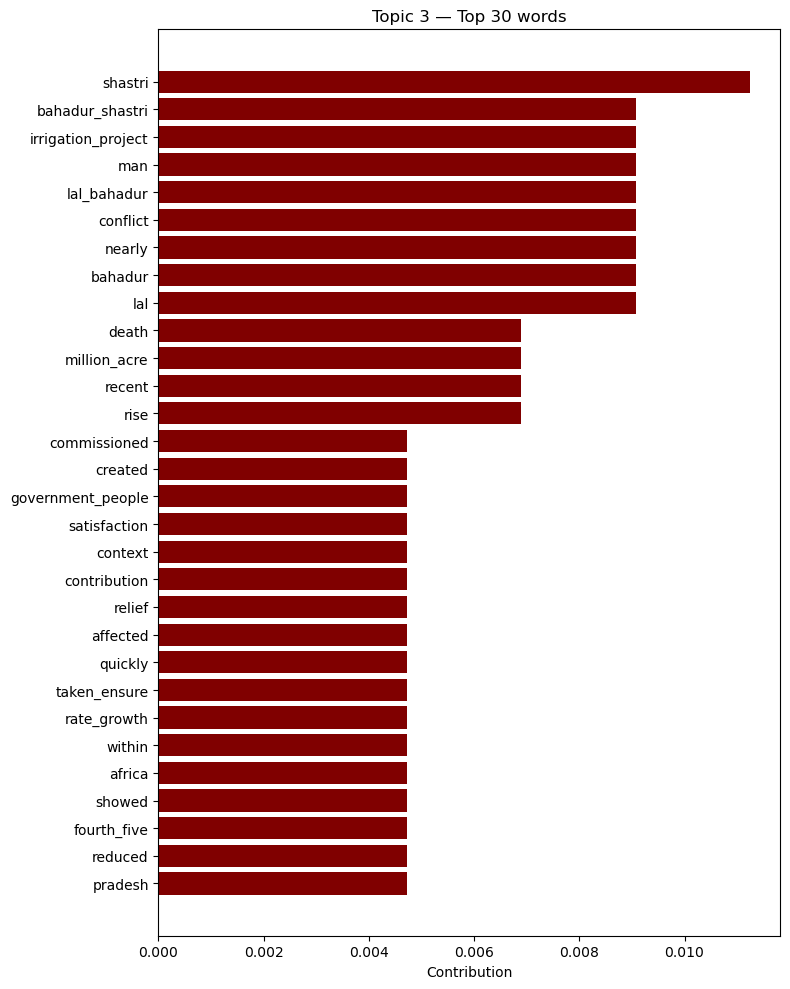


Topic 4
state_government 0.013175
food            0.013174
ordinance       0.010625
efficiency      0.010625
recommendation  0.010625
since           0.008075
leader          0.008075
shortly         0.008075
drought         0.005525
provision       0.005525
office          0.005525
failure         0.005525
failure_monsoon 0.005525
foundation      0.005525
vigour          0.005525
strengthened    0.005525
monsoon         0.005525
towards_end     0.005525
fullest         0.005525
occasion        0.005525
done            0.005525
chief           0.005525
preserving      0.005525
cast            0.005525
everything      0.005525
march           0.005525
achieve         0.005525
assam           0.005525
committee       0.005525
whether         0.005525


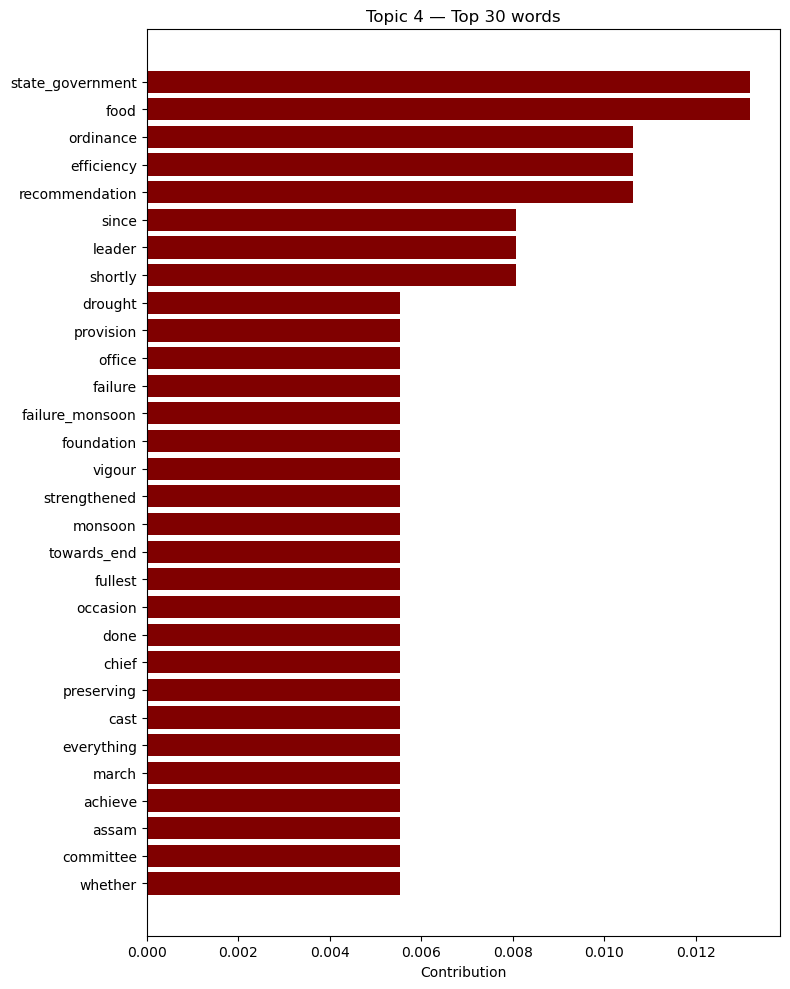


Topic 5
attack          0.013668
always          0.009235
emergency       0.009235
order           0.009235
soon            0.009235
thousand        0.009235
hoped           0.007019
territory       0.007019
started         0.007019
material        0.007019
village         0.007019
aid             0.007019
colombo         0.007019
question        0.007019
cause           0.007019
though          0.007019
citizen         0.007019
november        0.007019
progress_made   0.004802
coal            0.004802
base            0.004802
tradition       0.004802
registered      0.004802
troop           0.004802
democratic_socialist 0.004802
extent          0.004802
history         0.004802
committed       0.004802
plan_period     0.004802
fifty           0.004802


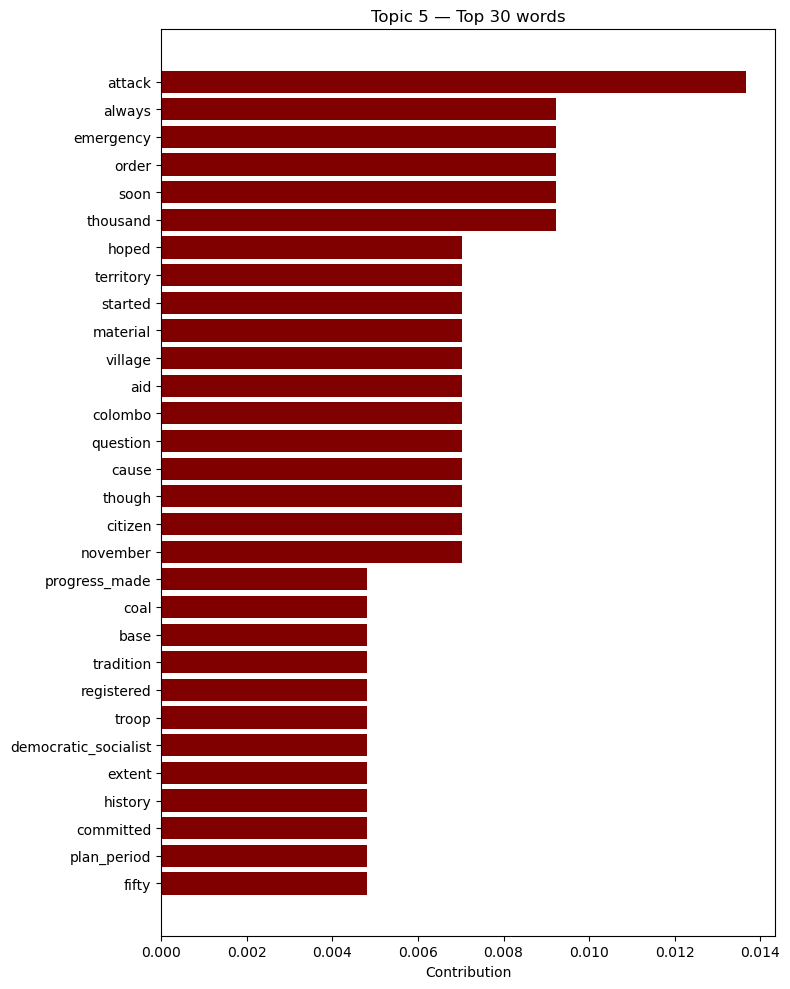

In [10]:
import matplotlib.pyplot as plt

def plot_lda_topics(lda_model, dictionary, topn=30):
    if lda_model is None:
        print("⚠️ Train the LDA model first.")
        return

    for t in range(lda_model.num_topics):
        # Get top terms
        terms = lda_model.get_topic_terms(t, topn=topn)
        terms = [(dictionary[id], float(weight)) for id, weight in terms]

        # Print top terms
        print(f"\nTopic {t}")
        for w, wt in terms:
            print(f"{w:15} {wt:.6f}")

        # Prepare for plotting
        words = [w for w, _ in terms][::-1]
        weights = [wt for _, wt in terms][::-1]

        # Plot horizontal bar chart
        plt.figure(figsize=(8, 10))
        plt.barh(words, weights, color="maroon")
        plt.title(f"Topic {t} — Top {topn} words")
        plt.xlabel("Contribution")
        plt.tight_layout()
        plt.show()

# --- Usage ---
if 'lda_model' in globals() and 'dictionary' in globals():
    plot_lda_topics(lda_model, dictionary, topn=30)
else:
    print("⚠️ Train the LDA model first.")


## 3e. Topic contribution per document and identify best 3 documents¶

In [11]:
import numpy as np

if 'lda_model' in globals():
    topic_contribs = []
    for i, bow in enumerate(corpus):
        doc_topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
        vec = [prob for _, prob in doc_topics]
        topic_contribs.append(vec)

    topic_contribs = np.array(topic_contribs)
    topic_cols = [f'Topic_{i}' for i in range(lda_model.num_topics)]
    contrib_ta = pd.DataFrame(topic_contribs, columns=topic_cols)
    contrib_ta['filename'] = ta['filename']

    best_docs_idx = topic_contribs.max(axis=1).argsort()[::-1][:3]
    print('Best 3 document indices:', best_docs_idx)
    for idx in best_docs_idx:
        print(idx, ta.loc[idx,'filename'])
        display(contrib_ta.loc[idx:idx])
else:
    print('Train LDA first.')

Best 3 document indices: [2 1 0]
2 radhakrishnan_17_02_1965.pdf


Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
2  0.000474  0.000475  0.997626  0.000475  0.000475  0.000475   

                       filename  
2  radhakrishnan_17_02_1965.pdf

1 radhakrishnan_14_02_1966.pdf


Topic_0  Topic_1   Topic_2   Topic_3   Topic_4  Topic_5  \
1  0.000479  0.00048  0.000481  0.997599  0.000481  0.00048   

                       filename  
1  radhakrishnan_14_02_1966.pdf

0 radhakrishnan_10_02_1964.pdf


Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
0  0.00048  0.997593  0.000482  0.000482  0.000481  0.000482   

                       filename  
0  radhakrishnan_10_02_1964.pdf

## 3f. Visualize topic contributions for the best 3 documents

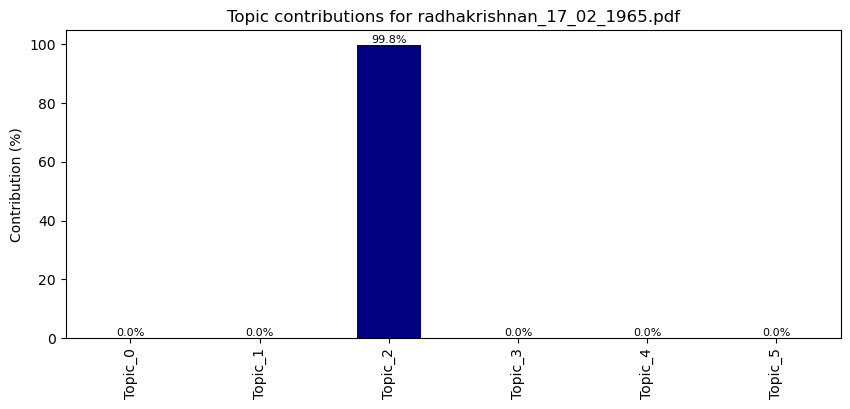

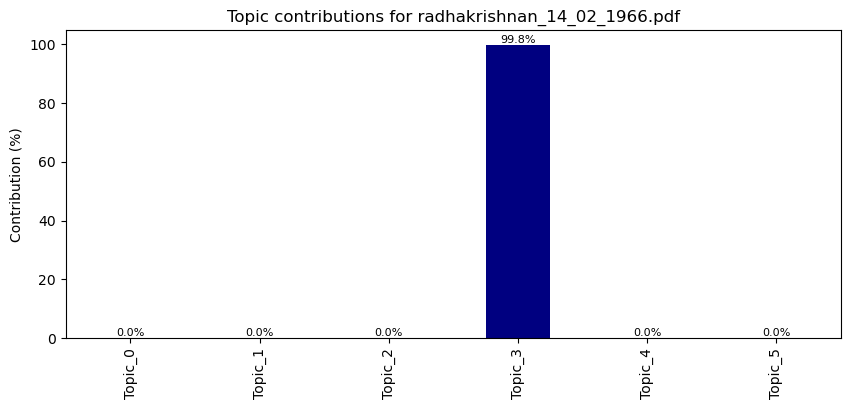

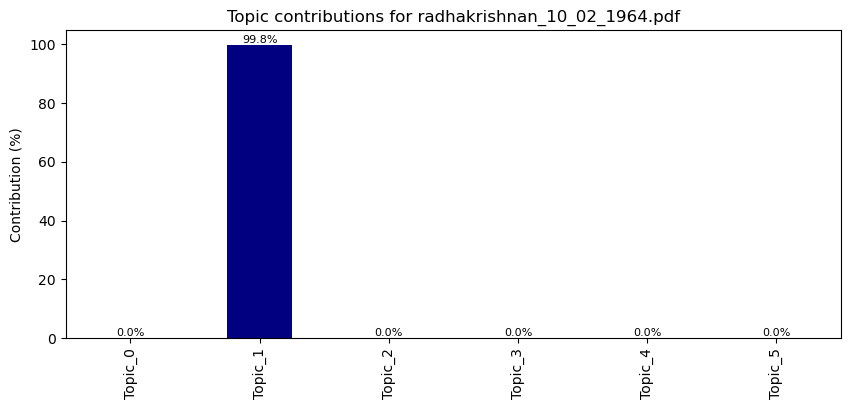

filename dominant_topic   Topic_0   Topic_1   Topic_2  \
2  radhakrishnan_17_02_1965.pdf        Topic_2  0.000474  0.000475  0.997626   
1  radhakrishnan_14_02_1966.pdf        Topic_3  0.000479  0.000480  0.000481   
0  radhakrishnan_10_02_1964.pdf        Topic_1  0.000480  0.997593  0.000482   

    Topic_3   Topic_4   Topic_5  
2  0.000475  0.000475  0.000475  
1  0.997599  0.000481  0.000480  
0  0.000482  0.000481  0.000482

In [12]:
import matplotlib.pyplot as plt

if 'contrib_ta' in globals():
    for idx in best_docs_idx:
        # Convert to percentages
        row = contrib_ta.loc[idx, topic_cols] * 100
        dominant = row.idxmax()

        # Assign colors (red for dominant topic)
        colors = ['grey'] * len(row)
        colors[list(row.index).index(dominant)] = 'navy'

        # Plot
        ax = row.plot(
            kind='bar', 
            color=colors, 
            figsize=(10,4),
            title=f"Topic contributions for {ta.loc[idx, 'filename']}"
        )
        ax.set_ylabel('Contribution (%)')

        # Add numeric labels above bars
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.1f}%",
                        (p.get_x() + p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', fontsize=8)

        plt.show()

    # --- Summary table for report ---
    contrib_ta['dominant_topic'] = contrib_ta[topic_cols].idxmax(axis=1)
    display(contrib_ta.loc[best_docs_idx, ['filename','dominant_topic'] + topic_cols])
else:
    print('Compute contrib_ta first.')


## 3g. Highlight sentences related to each topic in each selected document (HTML output)

In [18]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Add the sentencizer to the pipeline if it's not already there.
# This makes the code robust and prevents errors on reruns.
if 'sentencizer' not in nlp.pipe_names:
    nlp.add_pipe('sentencizer')

print("spaCy pipeline components:", nlp.pipe_names)

spaCy pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'sentencizer']


In [19]:
from IPython.display import HTML, display
from pathlib import Path
import re

# --- Make sure all your variables are loaded first ---
# lda_model, dictionary, ta, nlp, best_docs_idx, topic_labels, topic_colors
# You will also need your sentence_tokens function
# ----------------------------------------------------

# --- 1. Set Your Importance Threshold ---
# If too much is highlighted, INCREASE this number (e.g., to 0.5 or 0.6).
# If too little is highlighted, DECREASE it (e.g., to 0.35).
sentence_threshold = 0.50

# --- 2. Main Loop to Process Documents ---
for idx in best_docs_idx:
    # Get document text and split into sentences in their original order
    doc_row = ta.iloc[idx]
    doc_name = Path(doc_row["filename"]).stem
    text = str(doc_row["text"])
    sents = [sent.text.strip() for sent in nlp(text).sents if sent.text.strip()]

    # This list will hold each sentence, either plain or as highlighted HTML
    doc_parts = []

    # --- 3. Process Each Sentence Conditionally ---
    for sent in sents:
        toks = sentence_tokens(sent)
        if not toks:
            doc_parts.append(sent) # Add plain sentence and continue
            continue

        bow = dictionary.doc2bow(toks)
        dist = dict(lda_model.get_document_topics(bow, minimum_probability=0.0))

        if not dist:
            doc_parts.append(sent) # Add plain sentence and continue
            continue
            
        # Find the dominant topic and its probability score
        top_topic, top_prob = max(dist.items(), key=lambda item: item[1])

        # --- 4. The Highlighting Logic ---
        if top_prob >= sentence_threshold:
            # If the sentence is "important", wrap it in a colored span
            color = topic_colors.get(int(top_topic), '#dddddd')
            background_color = color + '4D' # Add transparency
            
            highlighted_span = (
                f"<span style='background-color:{background_color}; "
                f"padding: 2px 4px; border-radius: 4px;'>"
                f"{sent}"
                f"</span>"
            )
            doc_parts.append(highlighted_span)
        else:
            # Otherwise, add the sentence as plain text
            doc_parts.append(sent)

    # --- 5. Generate the Final HTML Output ---
    
    # First, create a color-coded legend for the topics
    legend_parts = ["<div style='padding: 10px; border: 1px solid #ddd; margin-bottom: 20px; border-radius: 5px;'><strong>Topic Legend:</strong><br/>"]
    for topic_id, label in topic_labels.items():
        color = topic_colors.get(topic_id, '#dddddd')
        legend_parts.append(f"<span style='background-color:{color}4D; padding: 2px 5px; border-radius: 4px; margin-right: 15px; display: inline-block; margin-top: 5px;'>{label}</span>")
    legend_parts.append("</div>")
    legend_html = "".join(legend_parts)
    
    # Join all the parts (plain and highlighted) into a single paragraph
    full_paragraph = ' '.join(doc_parts)

    # Combine everything for the final display
    full_html = (
        f"<html><body style='font-family:Arial, sans-serif; line-height: 1.7;'>"
        f"<h2>Document: {doc_name}</h2>"
        f"<p><i>(Highlighting sentences with topic probability ≥ {sentence_threshold})</i></p>"
        f"{legend_html}"
        f"<p>{full_paragraph}</p>"
        f"</body></html>"
    )

    display(HTML(full_html))
    
    # Save the output to a new folder
    out_dir = Path("./full_doc_highlights")
    out_dir.mkdir(exist_ok=True, parents=True)
    out_path = out_dir / f"{doc_name}_full_highlight.html"
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(full_html)
    print(f"✅ Saved highlighted document to: {out_path}")

✅ Saved highlighted document to: full_doc_highlights/radhakrishnan_18_02_1963_full_highlight.html


✅ Saved highlighted document to: full_doc_highlights/radhakrishnan_10_02_1964_full_highlight.html


✅ Saved highlighted document to: full_doc_highlights/radhakrishnan_14_02_1966_full_highlight.html


In [20]:
from IPython.display import HTML, display
from pathlib import Path
import re

# --- 1. NEW Helper Function to Darken Colors ---
# Add this function to your code.
def darken_color(hex_color, factor=0.6):
    """
    Creates a darker shade of a hex color.
    A factor of 0.6 means the color will be 40% darker.
    """
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    darker_rgb = tuple(int(max(0, c * factor)) for c in rgb)
    return f"#{darker_rgb[0]:02x}{darker_rgb[1]:02x}{darker_rgb[2]:02x}"

# --- 2. UPDATED Dual-Highlighting Function ---
# Replace your old version of this function with this new one.
def highlight_sentence_and_keywords(sent, top_words, topic_color):
    """
    Applies two layers of highlighting:
    1. A light, semi-transparent background for the sentence.
    2. A darker, opaque background for the keywords, derived from the topic color.
    """
    # Light background for the whole sentence (with transparency)
    sentence_background = topic_color + '4D' 
    
    # DYNAMICALLY create a darker color for the keywords
    keyword_background = darken_color(topic_color, factor=0.6)

    highlighted_text = sent
    for word in top_words:
        highlighted_text = re.sub(
            rf"\b({word})\b",
            # Set text color to white for better contrast on the dark background
            f"<span style='background-color:{keyword_background}; color:white; padding: 0 2px; border-radius: 3px; font-weight: 500;'>\\1</span>",
            highlighted_text,
            flags=re.IGNORECASE
        )
        
    final_html = (
        f"<span style='background-color:{sentence_background}; "
        f"padding: 2px 4px; border-radius: 4px;'>"
        f"{highlighted_text}"
        f"</span>"
    )
    return final_html

# --- 3. Main Loop (No changes needed here, just run it again) ---
# Set Your Importance Threshold
sentence_threshold = 0.50

for idx in best_docs_idx:
    doc_row = ta.iloc[idx]
    doc_name = Path(doc_row["filename"]).stem
    text = str(doc_row["text"])
    sents = [sent.text.strip() for sent in nlp(text).sents if sent.text.strip()]
    doc_parts = []

    for sent in sents:
        toks = sentence_tokens(sent)
        if not toks:
            doc_parts.append(sent)
            continue
        bow = dictionary.doc2bow(toks)
        dist = dict(lda_model.get_document_topics(bow, minimum_probability=0.0))
        if not dist:
            doc_parts.append(sent)
            continue
        top_topic, top_prob = max(dist.items(), key=lambda item: item[1])

        if top_prob >= sentence_threshold:
            top_words = [word for word, prop in lda_model.show_topic(int(top_topic), topn=15)]
            topic_color = topic_colors.get(int(top_topic), '#dddddd')
            highlighted_span = highlight_sentence_and_keywords(sent, top_words, topic_color)
            doc_parts.append(highlighted_span)
        else:
            doc_parts.append(sent)

    # --- Generate the Final HTML Output ---
    legend_parts = ["<div style='padding: 10px; border: 1px solid #ddd; margin-bottom: 20px; border-radius: 5px;'><strong>Topic Legend:</strong><br/>"]
    for topic_id, label in topic_labels.items():
        color = topic_colors.get(topic_id, '#dddddd')
        legend_parts.append(f"<span style='background-color:{color}4D; padding: 2px 5px; border-radius: 4px; margin-right: 15px; display: inline-block; margin-top: 5px;'>{label}</span>")
    legend_parts.append("</div>")
    legend_html = "".join(legend_parts)
    full_paragraph = ' '.join(doc_parts)

    full_html = (
        f"<html><body style='font-family:Arial, sans-serif; line-height: 1.7;'>"
        f"<h2>Document: {doc_name}</h2>"
        f"<p><i>(Highlighting sentences with topic probability ≥ {sentence_threshold})</i></p>"
        f"{legend_html}"
        f"<p>{full_paragraph}</p>"
        f"</body></html>"
    )
    display(HTML(full_html))
    
    out_dir = Path("./full_doc_highlights")
    out_dir.mkdir(exist_ok=True, parents=True)
    out_path = out_dir / f"{doc_name}_full_highlight.html"
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(full_html)
    print(f"✅ Saved highlighted document to: {out_path}")

✅ Saved highlighted document to: full_doc_highlights/radhakrishnan_18_02_1963_full_highlight.html


✅ Saved highlighted document to: full_doc_highlights/radhakrishnan_10_02_1964_full_highlight.html


✅ Saved highlighted document to: full_doc_highlights/radhakrishnan_14_02_1966_full_highlight.html


## 4. Sentiment Analysis & Emotion Annotation per Topic in Selected Documents

Installing necessary libraries... Please wait.
Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
failedg environment: - 

LibMambaUnsatisfiableError: Encountered problems while solving:
  - unsupported request
  - package gensim-4.3.0-py310h2b830bf_0 requires python >=3.10,<3.11.0a0 *_cpython, but none of the providers can be installed

Could not solve for environment specs
The following packages are incompatible
├─ gensim =* * is installable with the potential options
│  ├─ gensim [4.2.0|4.3.0|4.3.1|4.3.2|4.3.3] would require
│  │  └─ python >=3.10,<3.11.0a0 *_cpython, which can be installed;
│  ├─ gensim [4.2.0|4.3.0|4.3.1|4.3.2|4.3.3] would require
│  │  └─ python >=3.8,<3.9.0a0 *_cpython, which can be installed;
│  ├─ gensim [4.2.0|4.3.0|4.3.1|4.3.2|4.3.3] would require
│  │  └─ python >=3.9,<3.10.0a0 *_cpython, which can be installed;
│  ├─ gensim [4.3.1|4.3.2|4.3.3] woul


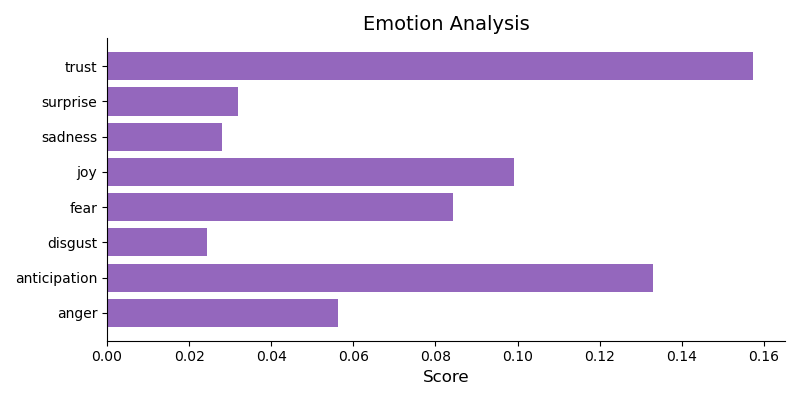
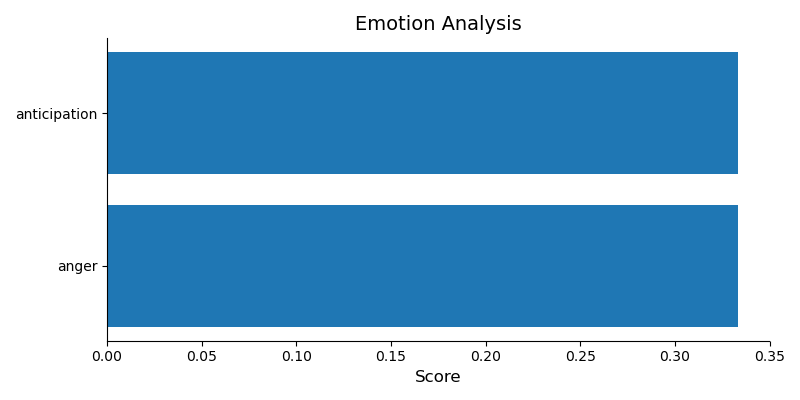
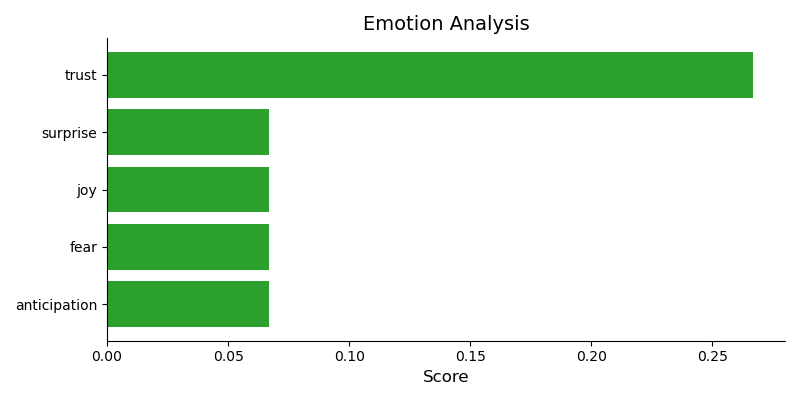

✅ Saved final analysis report to: final_analysis_report/radhakrishnan_18_02_1963_final_report.html



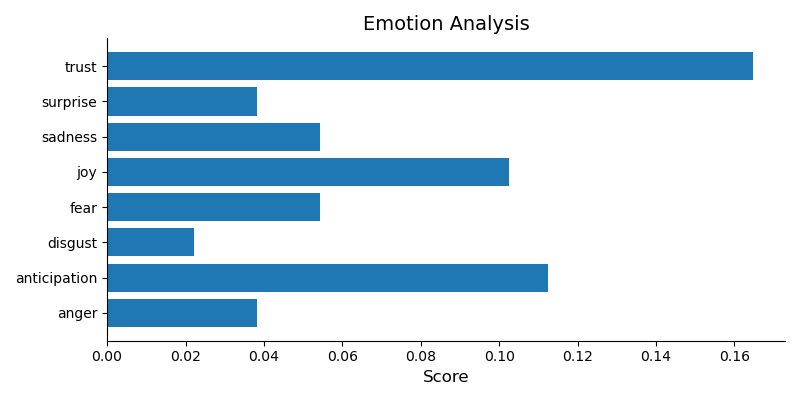
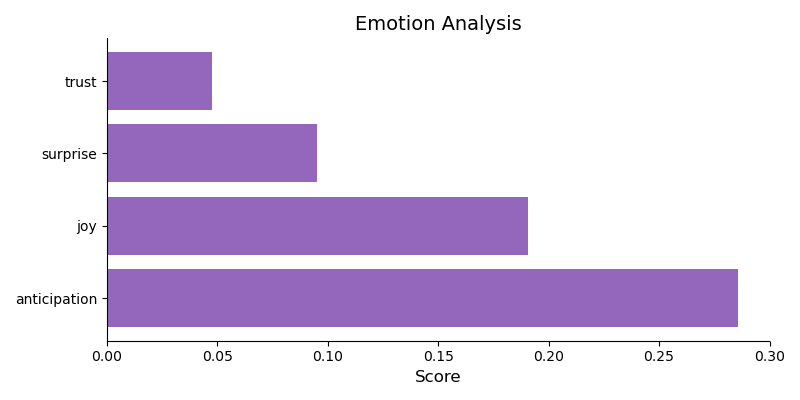
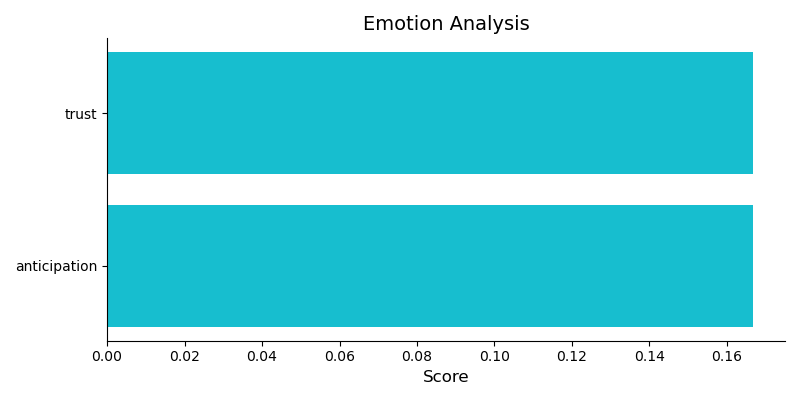
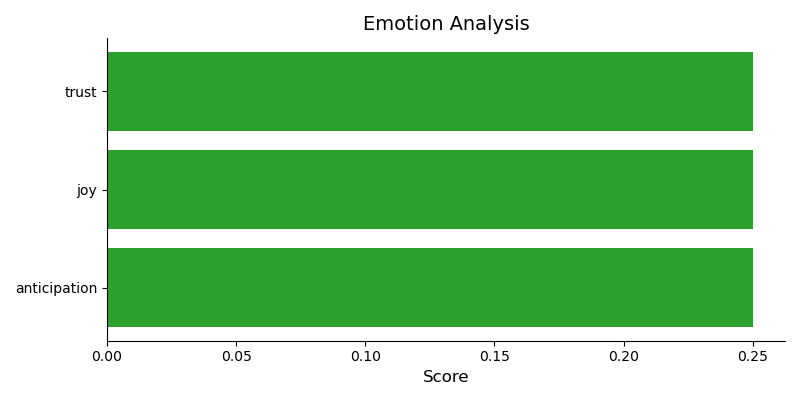

✅ Saved final analysis report to: final_analysis_report/radhakrishnan_10_02_1964_final_report.html



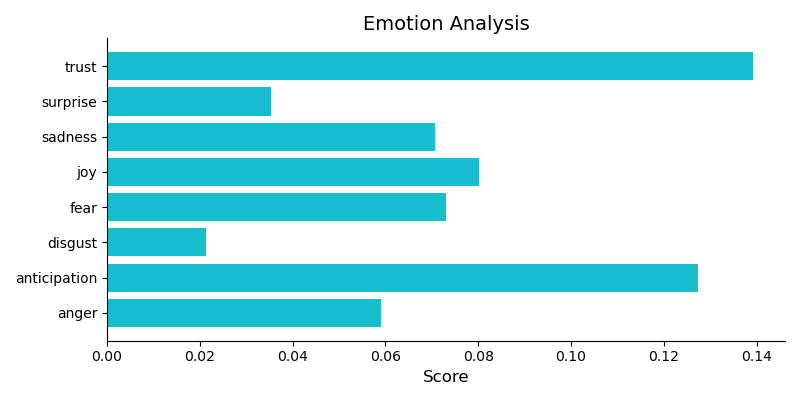
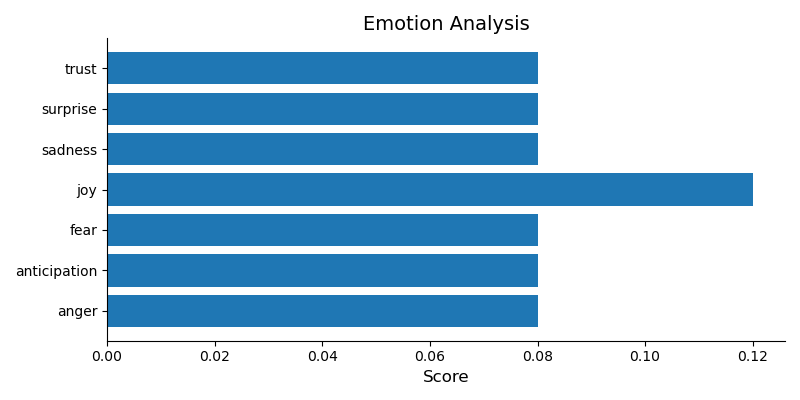
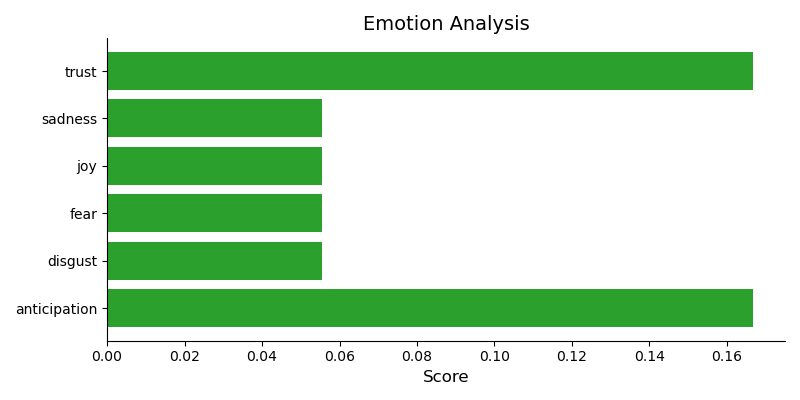
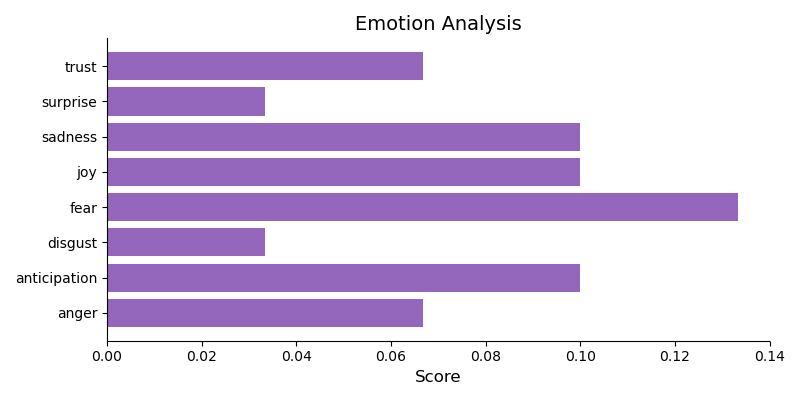

✅ Saved final analysis report to: final_analysis_report/radhakrishnan_14_02_1966_final_report.html


In [15]:
# --- 1. INSTALL LIBRARIES using Conda for better compatibility on Mac ---
print("Installing necessary libraries... Please wait.")
!conda install -c conda-forge gensim nrclex matplotlib --yes

# --- 2. IMPORTS ---
import pandas as pd
import numpy as np
from pathlib import Path
import re
import pdfplumber
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import spacy
from gensim import corpora, models
from nrclex import NRCLex
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from IPython.display import HTML, display

# --- 3. SETUP NLTK and SpaCy MODELS ---
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

# --- 4. DATA LOADING & PREPROCESSING (from your notebook) ---
pdf_path = Path("/Users/himanj/Downloads/Presidential_Addresses_in_their_Tenures/Dr S Radhakrishnan 1963-1967") # Your path
input_files = sorted(list(pdf_path.glob('*.pdf')))
records = []
for fp in input_files:
    text = ''
    with pdfplumber.open(fp) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + '\n'
    records.append({'filename': fp.name, 'text': text})
ta = pd.DataFrame(records)

stop_words = set(stopwords.words('english'))
custom_stops = {'honourable','members','government','president','india','shall','may','would', 'shri'}
stop_words |= custom_stops
lemmatizer = nltk.stem.WordNetLemmatizer()

def sentence_tokens(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens if (t not in stop_words and len(t) > 2)]
    return lemmas

ta['tokens'] = ta['text'].apply(sentence_tokens)
print(f"{len(ta)} documents loaded and preprocessed.")

# --- 5. CREATE CORPUS & TRAIN LDA MODEL ---
dictionary = corpora.Dictionary(ta['tokens'])
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in ta['tokens']]

best_k = 6
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_k, random_state=100, passes=15)
print(f"LDA model trained with {best_k} topics.")

# --- 6. DEFINE TOPIC LABELS & COLORS ---
topic_labels = {
    0: "Defense, Territory, International Relations", 1: "Economic Action & Social Issues",
    2: "Food Policy & National Income", 3: "Prime Minister Shastri, Conflict & Relief",
    4: "Government, Administration & Policy", 5: "Military Action & National Emergency"
}
topic_colors = {
    0: '#1f77b4', 1: '#2ca02c', 2: '#9467bd',
    3: '#e377c2', 4: '#bcbd22', 5: '#17becf'
}

# --- 7. HELPER FUNCTION for the Bar Chart ---
def create_emotion_bar_chart(emotion_scores, topic_color):
    """Generates a base64-encoded bar chart image for emotion scores."""
    filtered_scores = {emotion: score for emotion, score in emotion_scores.items() if score > 0}
    
    if not filtered_scores:
        return "<p>No prominent emotions detected in this topic's text.</p>"

    # --- THIS IS THE LINE TO CHANGE ---
    # Original was (5, 3). Let's make it wider and taller.
    fig, ax = plt.subplots(figsize=(8, 4)) 
    # ------------------------------------

    emotions = list(filtered_scores.keys())
    scores = list(filtered_scores.values())
    
    ax.barh(emotions, scores, color=topic_color)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_title('Emotion Analysis', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping

    # Save the plot to a memory buffer
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    
    # Encode the image in base64 to embed it in HTML
    img_data = base64.b64encode(buf.getvalue()).decode('utf-8')
    return f'<img src="data:image/png;base64,{img_data}">'

# --- 8. MAIN LOOP FOR QUESTION 4 ---

# --- THIS IS THE CORRECTED SECTION ---
# Get the topic distribution for each document in the corpus
doc_topics_list = lda_model.get_document_topics(corpus, minimum_probability=0.0)

# For each document, find the highest topic probability
max_probs = [max([prob for _, prob in doc]) if doc else 0 for doc in doc_topics_list]

# Get the indices of the top 3 documents based on these max probabilities
best_docs_idx = np.array(max_probs).argsort()[::-1][:3]
# --- END OF CORRECTION ---

print(f"\nAnalyzing top 3 documents with indices: {best_docs_idx}")
sentence_threshold = 0.40

for idx in best_docs_idx:
    doc_row = ta.iloc[idx]
    doc_name = Path(doc_row["filename"]).stem
    text = str(doc_row["text"])
    sents = [sent.text.strip() for sent in nlp(text).sents if sent.text.strip()]
    
    topic_sentences = {t: [] for t in range(lda_model.num_topics)}
    for sent in sents:
        toks = sentence_tokens(sent)
        if not toks: continue
        bow = dictionary.doc2bow(toks)
        dist = dict(lda_model.get_document_topics(bow, minimum_probability=0.0))
        if not dist: continue
        top_topic, top_prob = max(dist.items(), key=lambda item: item[1])
        if top_prob >= sentence_threshold:
            topic_sentences[int(top_topic)].append((sent, float(top_prob)))

    html_parts = [f"<h2>Document: {doc_name}</h2>", f"<p>Showing sentences with topic probability ≥ {sentence_threshold}</p><hr>"]
    
    sorted_topics = sorted(topic_sentences.items(), key=lambda item: len(item[1]), reverse=True)
    
    for topic_id, sents_for_topic in sorted_topics:
        if not sents_for_topic: continue
        color = topic_colors.get(topic_id, '#000000')
        label = topic_labels.get(topic_id, f"Topic {topic_id}")
        
        html_parts.append(f"<div style='border-left: 6px solid {color}; padding: 10px; margin: 20px 0; border-radius: 5px; background-color: #f9f9f9;'>")
        html_parts.append(f"<h3 style='color:{color}; margin-top:0;'>{label}</h3>")
        
        full_topic_text_display = "".join([f"<p style='margin-bottom: 5px;'><b>[Score: {p:.2f}]</b> {s}</p>" for s, p in sents_for_topic])
        html_parts.append(f"<div style='line-height: 1.7;'>{full_topic_text_display}</div>")

        topic_text_for_analysis = ' '.join([sent for sent, prob in sents_for_topic])
        nrc_object = NRCLex(topic_text_for_analysis)
        all_scores = nrc_object.affect_frequencies
        
        sentiment_scores = {"Positive": all_scores.get('positive', 0), "Negative": all_scores.get('negative', 0)}
        required_emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]
        emotion_scores = {emo: all_scores.get(emo, 0) for emo in required_emotions}
        
        html_parts.append("<div style='margin-top: 15px; padding: 10px; border-top: 2px solid #eee; display: flex; align-items: flex-start; flex-wrap: wrap;'>")
        html_parts.append(f"<div style='flex: 1; min-width: 150px; padding-right: 10px;'><h4>Sentiment</h4><p><b>Positive Score:</b> {sentiment_scores['Positive']:.2f}<br/><b>Negative Score:</b> {sentiment_scores['Negative']:.2f}</p></div>")
        html_parts.append(f"<div style='flex: 2; min-width: 300px;'>{create_emotion_bar_chart(emotion_scores, color)}</div>")
        html_parts.append("</div></div>")

    full_html = "<html><body style='font-family:Arial, sans-serif;'>" + "".join(html_parts) + "</body></html>"
    display(HTML(full_html))
    
    out_dir = Path("./final_analysis_report")
    out_dir.mkdir(exist_ok=True, parents=True)
    out_path = out_dir / f"{doc_name}_final_report.html"
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(full_html)
    print(f"✅ Saved final analysis report to: {out_path}")

## 5. Transliteration of the assigned Data into Regional Languages

## English to Konkani

In [8]:
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

# Example: transliterate first document
sample_text = ta.loc[0, "text"][:1000]  # first 1000 chars

# English → Devanagari (Konkani script)
transliterated_text = transliterate(sample_text, sanscript.ITRANS, sanscript.DEVANAGARI)

print("Original (English):\n", sample_text[:1000])
print("\nTransliterated (Konkani script - Devanagari):\n", transliterated_text[:1000])


Original (English):
 ADDRESS TO PARLIAMENT—10 FEBRUARY 1964*
Lok Sabha — Third Lok Sabha
Session — First Session of the Year
President of India — Dr. S. Radhakrishnan
Vice-President of India — Dr. Zakir Husain
Prime Minister of India — Pt. Jawaharlal Nehru
Speaker, Lok Sabha — Sardar Hukam Singh
MEMBERS OF PARLIAMENT,
I am happy to welcome you once again to your labours in a new session
of Parliament.
In the year which has just ended, the Government and the people of
India have had to face problems which were vast in magnitude and complex
in character. In spite of difficulties and distractions, we have continued to
move forward towards our objective of a democratic and socialist order at
home and for peace and co-operation in international affairs.
The mid-term appraisal of our Third Five-Year Plan under-taken by the
Planning Commission has revealed that the ground to be covered in the
remaining two years is considerable and an all-out effort would be required
to realise our expectatio